<a href="https://colab.research.google.com/github/moskalt/DLnotebooks/blob/main/pytorch_mnist_training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [154]:
import torch
import torchvision
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor
from torchvision.utils import make_grid
from torch.utils.data.dataloader import DataLoader
from torch.utils.data import random_split
%matplotlib inline

# Use a white background for matplotlib figures
matplotlib.rcParams['figure.facecolor'] = '#ffffff'

In [155]:
dataset = MNIST(root='data/', download=True,transform=ToTensor())

image.shape: torch.Size([1, 28, 28])
Label: 5


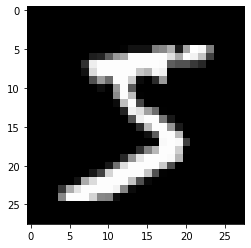

In [156]:
image, label = dataset[0]
print('image.shape:', image.shape)
plt.imshow(image[0,:,:], cmap='gray')
print('Label:', label)

In [157]:
val_size = 10000
train_size = len(dataset) - val_size

train_ds, val_ds = random_split(dataset, [train_size, val_size])

In [158]:
batch_size = 128
train_loader = DataLoader(train_ds, batch_size, shuffle=True, num_workers=4, pin_memory=True)
val_loader = DataLoader(val_ds, batch_size*2, num_workers=4, pin_memory=True)

images.shape: torch.Size([128, 1, 28, 28])


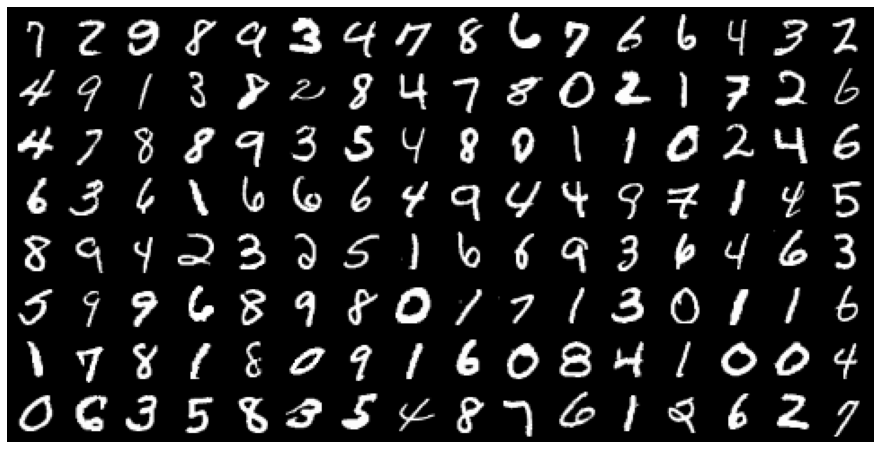

In [159]:
for images, _ in train_loader:
    print('images.shape:', images.shape)
    plt.figure(figsize=(16,8))
    plt.axis('off')
    plt.imshow(make_grid(images, nrow=16).permute((1, 2, 0)))
    break

In [160]:
for images, labels in train_loader:
    print('images.shape:', images.shape)
    inputs = images.reshape(-1, 784)
    print('inputs.shape:', inputs.shape)
    break

images.shape: torch.Size([128, 1, 28, 28])
inputs.shape: torch.Size([128, 784])


In [161]:
input_size = inputs.shape[-1]
hidden_size = 32

In [162]:
layer1 = nn.Linear(input_size, hidden_size)

In [163]:
input_size

784

In [164]:
inputs.shape

torch.Size([128, 784])

In [165]:
layer1_outputs = layer1(inputs)
print('layer1_outputs.shape:', layer1_outputs.shape)

layer1_outputs.shape: torch.Size([128, 32])


In [166]:
relu_outputs = F.relu(layer1_outputs)
print('min(layer1_outputs):', torch.min(layer1_outputs).item())
print('min(relu_outputs):', torch.min(relu_outputs).item())

min(layer1_outputs): -0.6174123287200928
min(relu_outputs): 0.0


In [167]:
output_size = 10
layer2 = nn.Linear(hidden_size, output_size)

In [168]:
layer2_outputs = layer2(relu_outputs)

In [169]:
F.cross_entropy(layer2_outputs, labels)

tensor(2.3196, grad_fn=<NllLossBackward>)

In [170]:
outputs = (F.relu(inputs @ layer1.weight.t() + layer1.bias)) @ layer2.weight.t() + layer2.bias

In [171]:
torch.allclose(outputs, layer2_outputs, 1e-3)



True

In [172]:
outputs2 = (inputs @ layer1.weight.t() + layer1.bias) @ layer2.weight.t() + layer2.bias

In [173]:
combined_layer = nn.Linear(input_size, output_size)

In [174]:
combined_layer.weight.data = layer2.weight @ layer1.weight
combined_layer.bias.data = layer1.bias @ layer2.weight.t() + layer2.bias

In [175]:
outputs3 = inputs @ combined_layer.weight.t() + combined_layer.bias

In [176]:
torch.allclose(outputs2, outputs3, 1e-3)

True

In [177]:
class MnistModel(nn.Module):
    def __init__(self,in_size,hidden_size,hidden_size2,out_size):
        super().__init__()

        self.linear1 = nn.Linear(in_size, hidden_size)
        self.relu1 = nn.ReLU(inplace=False)
        self.linear2 = nn.Linear(hidden_size, hidden_size2)
        self.relu2 = nn.ReLU(inplace=False)
        self.linear3 = nn.Linear(hidden_size2, out_size)

    def forward(self, x):
        x = x.view(x.size(0), -1)
        out = self.linear1(x)
        out = self.relu1(out)
        out = self.linear2(out)
        out = self.relu2(out)
        out = self.linear3(out)
        return out

    def training_step(self, batch):
        images, labels = batch
        out = self(images)
        loss = F.cross_entropy(out, labels)
        return loss

    def validation_step(self, batch):
        images, labels = batch
        out = self(images)
        loss = F.cross_entropy(out, labels)
        acc = accuracy(out, labels)
        return {'val_loss' : loss, 'val_acc' : acc }

    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_accs = torch.stack(batch_accs).mean()
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_accs.item()}

    def epoch_end(self, epoch, result):
        print("Epoch [{}], val_loss: {:.4f}, val_acc: {:.4f}".format(epoch, result['val_loss'], result['val_acc']))

In [178]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

In [179]:
input_size = 784
hidden_size = 256
hidden_size2 = 80
num_classes = 10

In [180]:
model = MnistModel(in_size=784, hidden_size = 256,hidden_size2 = 100 ,out_size=num_classes)

In [181]:
for t in model.parameters():
    print(t.shape)

torch.Size([256, 784])
torch.Size([256])
torch.Size([100, 256])
torch.Size([100])
torch.Size([10, 100])
torch.Size([10])


In [182]:
for images, labels in train_loader:
    outputs = model(images)
    loss = F.cross_entropy(outputs, labels)
    print('Loss:', loss.item())
    break

print('outputs.shape : ', outputs.shape)
print('Sample outputs :\n', outputs[:2].data)

Loss: 2.2901828289031982
outputs.shape :  torch.Size([128, 10])
Sample outputs :
 tensor([[ 0.0024,  0.0590,  0.0685,  0.0031, -0.0580, -0.0851, -0.0410, -0.0491,
          0.0428, -0.0748],
        [ 0.0031,  0.0692,  0.0675, -0.0092, -0.0894, -0.1053, -0.0413, -0.0486,
          0.0597, -0.0595]])


In [183]:
torch.cuda.is_available()

True

In [184]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

In [185]:
device = get_default_device()

In [186]:
device

device(type='cuda')

In [187]:
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

In [188]:
for images, labels in train_loader:
    print(images.shape)
    images = to_device(images, device)
    print(images.device)
    break

torch.Size([128, 1, 28, 28])
cuda:0


In [189]:
class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [190]:
train_loader = DeviceDataLoader(train_loader, device)
val_loader = DeviceDataLoader(val_loader, device)

In [191]:
for xb, yb in val_loader:
    print('xb.device:', xb.device)
    print('yb:', yb)
    break

xb.device: cuda:0
yb: tensor([0, 1, 1, 8, 7, 4, 4, 8, 8, 4, 4, 7, 1, 9, 2, 1, 3, 8, 0, 4, 4, 7, 7, 7,
        6, 6, 7, 9, 8, 5, 7, 0, 8, 7, 9, 9, 3, 9, 8, 2, 7, 5, 7, 0, 2, 7, 6, 0,
        0, 0, 0, 1, 6, 9, 8, 6, 8, 8, 4, 1, 4, 7, 1, 0, 0, 1, 2, 2, 4, 5, 2, 0,
        4, 2, 2, 6, 3, 2, 7, 0, 3, 8, 6, 3, 2, 8, 6, 2, 8, 3, 9, 1, 6, 7, 5, 2,
        8, 4, 8, 1, 4, 1, 7, 8, 8, 0, 3, 3, 2, 4, 0, 4, 3, 0, 8, 4, 9, 8, 9, 7,
        3, 6, 0, 4, 3, 7, 6, 1, 5, 4, 5, 0, 3, 8, 2, 2, 7, 1, 3, 1, 6, 2, 4, 2,
        8, 7, 9, 7, 3, 3, 2, 1, 0, 4, 3, 8, 3, 0, 3, 0, 1, 7, 0, 2, 8, 7, 0, 7,
        9, 7, 0, 7, 6, 2, 6, 2, 4, 3, 2, 0, 4, 5, 5, 1, 6, 2, 8, 7, 6, 8, 9, 4,
        3, 2, 2, 4, 3, 5, 1, 9, 7, 2, 8, 8, 7, 9, 3, 5, 6, 9, 0, 3, 6, 2, 0, 8,
        7, 9, 2, 5, 4, 7, 6, 2, 9, 6, 1, 1, 2, 9, 2, 5, 4, 8, 2, 2, 5, 5, 4, 1,
        1, 3, 9, 6, 7, 1, 8, 1, 2, 1, 0, 7, 0, 6, 3, 3], device='cuda:0')


In [192]:
def evaluate(model, val_loader):
    """Evaluate the model's performance on the validation set"""
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

In [193]:
def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    """Train the model using gradient descent"""
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase 
        for batch in train_loader:
            loss = model.training_step(batch)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [194]:
model = MnistModel(input_size, hidden_size=hidden_size,hidden_size2=hidden_size2, out_size=num_classes)
#to_device(model, device)


In [195]:
to_device(model, device)

MnistModel(
  (linear1): Linear(in_features=784, out_features=256, bias=True)
  (relu1): ReLU()
  (linear2): Linear(in_features=256, out_features=80, bias=True)
  (relu2): ReLU()
  (linear3): Linear(in_features=80, out_features=10, bias=True)
)

In [196]:
history = [evaluate(model, val_loader)]
history


[{'val_acc': 0.10146484524011612, 'val_loss': 2.303750514984131}]

In [197]:
history += fit(5, 0.5, model, train_loader, val_loader)

Epoch [0], val_loss: 0.2097, val_acc: 0.9343
Epoch [1], val_loss: 0.1237, val_acc: 0.9630
Epoch [2], val_loss: 0.1160, val_acc: 0.9635
Epoch [3], val_loss: 0.1058, val_acc: 0.9679
Epoch [4], val_loss: 0.0734, val_acc: 0.9763


In [198]:
history += fit(5, 0.1, model, train_loader, val_loader)

Epoch [0], val_loss: 0.0672, val_acc: 0.9795
Epoch [1], val_loss: 0.0670, val_acc: 0.9778
Epoch [2], val_loss: 0.0667, val_acc: 0.9791
Epoch [3], val_loss: 0.0678, val_acc: 0.9785
Epoch [4], val_loss: 0.0660, val_acc: 0.9796


In [199]:
history += fit(10, 0.001, model, train_loader, val_loader)

Epoch [0], val_loss: 0.0658, val_acc: 0.9792
Epoch [1], val_loss: 0.0656, val_acc: 0.9794
Epoch [2], val_loss: 0.0655, val_acc: 0.9793
Epoch [3], val_loss: 0.0655, val_acc: 0.9795
Epoch [4], val_loss: 0.0654, val_acc: 0.9795
Epoch [5], val_loss: 0.0654, val_acc: 0.9796
Epoch [6], val_loss: 0.0654, val_acc: 0.9799
Epoch [7], val_loss: 0.0653, val_acc: 0.9798
Epoch [8], val_loss: 0.0653, val_acc: 0.9799
Epoch [9], val_loss: 0.0653, val_acc: 0.9799


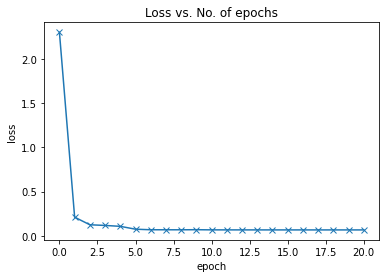

In [200]:
losses = [x['val_loss'] for x in history]
plt.plot(losses, '-x')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('Loss vs. No. of epochs');

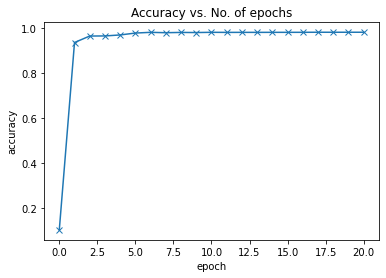

In [201]:
accuracies = [x['val_acc'] for x in history]
plt.plot(accuracies, '-x')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.title('Accuracy vs. No. of epochs');

In [202]:
test_dataset = MNIST(root='data/', 
                     train=False,
                     transform=ToTensor())

In [203]:
test_loader = DeviceDataLoader(DataLoader(test_dataset, batch_size=256), device)
result = evaluate(model, test_loader)
result

{'val_acc': 0.9833008050918579, 'val_loss': 0.05819366127252579}